In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import make_scorer, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [10]:
data = pd.read_csv('./data/data_indexes_moex_log_returns.csv', index_col=0)

In [11]:
from typing import List, Union, Tuple

def MASE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Mean Absolute Scaled Error (MASE) между фактическими и прогнозируемыми значениями.

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение MASE.
    '''
    # Создание наивного прогноза с использованием сдвига временного ряда
    naive_forecast = y_true.shift(1)
    naive_forecast.iloc[0] = y_true.iloc[0]

    # Вычисление средней абсолютной ошибки для модели и наивного прогноза
    average_errors = np.abs(y_true - y_pred)
    naive_average_errors = np.abs(y_true - naive_forecast)

    result = np.mean(average_errors) / np.mean(naive_average_errors)
    return result


def ZBMAE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Zero-Benchmarked Mean Absolute Error (ZBMAE) между фактическими и прогнозируемыми значениями.

    ZBMAE сравнивает среднюю абсолютную ошибку прогноза с средней абсолютной ошибкой наивного прогноза, который предполагает, что все прогнозируемые значения равны нулю. Это может быть полезно для временных рядов, где ожидается, что значения будут вокруг нуля.

    Параметры:
        y_true (pd.Series): Серия с фактическими значениями.
        y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
        float: Значение ZBMAE.
    '''
    zero_forecast = 0

    average_errors = np.abs(y_true - y_pred)
    naive_average_errors = np.abs(y_true - zero_forecast)

    result = np.mean(average_errors) / np.mean(naive_average_errors.mean())
    return result

def SMAPE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Symmetric Mean Absolute Percentage Error (SMAPE) между фактическими и прогнозируемыми значениями.

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение SMAPE.
    '''
    # Избегание деления на ноль добавлением небольшого числа в знаменатель
    denominator = (np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps) / 2
    result = (100 / len(y_true)) * np.sum(np.abs(y_pred - y_true) / denominator)
    return result

def MDA(y_true: pd.Series, y_pred: pd.Series) -> float:

    '''
    Вычисляет Mean Directional Accuracy (MDA) между фактическими и прогнозируемыми значениями.

    MDA измеряет процент времени, когда прогноз и фактическое значение имеют одинаковое направление изменений (например, оба увеличиваются или оба уменьшаются).

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение MDA в процентах.
    '''

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    actual_diff = np.diff(y_true)
    actual_signs = np.sign(actual_diff)
    predicted_diff = np.diff(y_pred)
    predicted_signs = np.sign(predicted_diff)
    
    num_correct = np.sum(actual_signs == predicted_signs)
    
    mda = num_correct / (len(y_true) - 1)
    return 100*mda


def DMDA(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Direct Mean Directional Accuracy (DMDA) между фактическими и прогнозируемыми значениями.
    

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение MDA в процентах.
    '''
    y_true_sign = np.sign(y_true)
    y_pred_sign = np.sign(y_pred)

    result = (100 / len(y_true)) * np.sum(y_pred_sign == y_true_sign)
    return result

class TimeSeriesProcessor:
    '''
    Класс для работы с временными рядами, включая добавление лагов, интеграцию внешних переменных,
    создание разбиений для валидации, вычисление метрик и визуализацию результатов.

    Методы:
        add_lags(self, lags: List[int], drop_na: bool = True):
            Добавление лагов к переменным временного ряда.
        add_other_variables(self, other_variables: pd.DataFrame):
            Добавление дополнительных переменных к данным.
        get_folds(self, horizon: int = 25):
            Создание разбиений данных для тестирования.
        get_model_result(self, y_pred_list: List[pd.Series]):
            Вычисление и вывод метрик для модели.
        get_visualisation(self):
            Визуализация фактических и прогнозируемых значений.
    '''
    def __init__(
            self, 
            data: Union[pd.Series, pd.DataFrame], 
            target_name: str = None,
            interpolate: bool = True,
            dropna: bool = True
            ) -> None:
        '''
        Инициализирует объект класса с данными временного ряда.

        Параметры:
            data (Union[pd.Series, pd.DataFrame]): Временной ряд в формате pd.Series или pd.DataFrame.
            target_name (str, опционально): Имя целевой переменной в случае pd.DataFrame.
            interpolate (bool): Необходимо ли интерполировать данные.
            dropna (bool): Необходимо ли удалить пропущенные значения.
        '''
        if not isinstance(data.index, pd.DatetimeIndex):
            print('Новый тип индексов: pd.DatetimeIndex')
            data.index = pd.to_datetime(data.index)
        
        if interpolate:
            data = data.interpolate(method='time')
        
        if dropna:
            data = data.dropna()

        data = data.sort_index()

        if isinstance(data, pd.Series):
            if target_name is not None:
                print("Предупреждение: target_name не нужно указывать для data: pd.Series")
            self.y = data
            self.X = pd.DataFrame(index=self.y.index)
        else:
            if target_name is None:
                raise ValueError("target_name обязательный параметр для data: pd.DataFrame")
            self.y = data[target_name]
            self.X = data.drop([target_name], axis=1)

        self.get_folds_was_called = False
        self.y_pred = None

        self.y_val = None
        self.X_val = None

    def add_lags(self, lags: List[int], drop_na: bool = True) -> None:
        '''
        Добавляет лаги (отставания) к временному ряду как новые признаки.

        Параметры:
            lags (List[int]): Список целых чисел, каждое из которых указывает на количество шагов отставания.
            drop_na (bool): Если True, то строки с пропущенными значениями после добавления лагов будут удалены.
        '''
        for lag in lags:
            self.X[f'lag_{lag}'] = self.y.shift(lag)

        if drop_na:
            self.X.dropna(inplace=True)
            self.y = self.y.loc[self.X.index]

        if self.get_folds_was_called:
            self.get_folds(horizon=self.horizon)

    def add_other_variables(self, other_variables: pd.DataFrame = None, date_variables: bool = False) -> None:
        '''
        Добавляет дополнительные внешние переменные к данным временного ряда.

        Параметры:
            other_variables (pd.DataFrame): DataFrame, содержащий внешние переменные для добавления.
            date_variables (bool): Будут ли добавлены переменные, связанные с датой.
        '''

        if other_variables is not None:
            if other_variables.isna().any().any():
                print('Предупреждение: в other_variables есть пропуски. Алгоритм не предусматривает их наличие')

            self.X = pd.concat([self.X, other_variables], axis=1, join='inner')


        if date_variables:
            self.X['days_since_start'] = (self.X.index - self.X.index[0]).days
            self.X['day'] = self.X.index.day
            self.X['dayofweek'] = self.X.index.dayofweek
            self.X['month'] = self.X.index.month
            self.X['year'] = self.X.index.year


        if self.get_folds_was_called:
            self.get_folds(horizon=self.horizon)

    def get_folds(
            self, 
            horizon: int = 25, 
            num_recent_folds: int = None, 
            validation_part: float = None
            ) -> None:
        '''
        Создает разбиения данных для кросс-валидации на основе указанного горизонта прогнозирования.

        Параметры:
            horizon (int): Горизонт прогнозирования, используемый для создания тестовых разбиений.
            num_recent_folds (int, optional): Количество последних разбиений для включения в результат.
                Если не указано, используются все разбиения.
            validation_part (float): Процентное отношение объема исходных данных, отводимое для валидационного набора. Этот параметр особенно полезен в случаях, когда оптимизация гиперпараметров модели требует значительного времени. Рекомендуется однократно настроить гиперпараметры на валидационном наборе и применять их для последующих разбиений (фолдов), избегая повторного обучения на каждом фолде.
                В случае отсутствия значения параметра, валидационная часть данных не формируется.
        '''

        if validation_part is not None:
            if not 0 <= validation_part <= 1:
                raise ValueError("validation_part может быть только числом в отрезке от 0 до 1 включительно")
            
            last_val_obs = int(self.y.shape[0] * validation_part)

            self.y_val, self.y = self.y.iloc[:last_val_obs], self.y.iloc[last_val_obs:]
            self.X_val, self.X = self.X.iloc[:last_val_obs, :], self.X.iloc[last_val_obs:, :]

        self.horizon = horizon
        self.folds = []
        for i in range(0, len(self.X) - horizon, horizon):
            X_test = self.X.iloc[i:i + horizon]
            y_test = self.y.iloc[i:i + horizon]

            X_train = self.X.drop(X_test.index)
            y_train = self.y.drop(y_test.index)
            
            self.folds.append((X_train, y_train, X_test, y_test))
        
        if num_recent_folds is not None:
            self.folds = self.folds[-num_recent_folds:]
        
        self.get_folds_was_called = True

    def get_model_result(self, y_pred_list: List[pd.Series]) -> None:
        '''
        Вычисляет и выводит метрики качества модели на основе совокупности предсказаний.

        Параметры:
            y_pred_list (List[pd.Series]): Список pd.Series с прогнозами модели для каждого разбиения.
        '''
        self.y_pred = pd.concat(y_pred_list)
        self.y_true = self.y.loc[self.y_pred.index]

        self.mase = MASE(self.y_true, self.y_pred)
        self.smape = SMAPE(self.y_true, self.y_pred)
        self.mda = MDA(self.y_true, self.y_pred)
        self.dmda = DMDA(self.y_true, self.y_pred)
        self.zbmae = ZBMAE(self.y_true, self.y_pred)
        self.mae = mean_absolute_error(self.y_true, self.y_pred)

        print(f'MAE: {self.mae:.2f}')
        print(f'MASE: {self.mase:.2f}')
        print(f'ZBMAE: {self.zbmae:.2f}')
        print(f'SMAPE: {self.smape:.2f}%')
        print(f'MDA: {self.mda:.2f}%')
        print(f'DMDA: {self.dmda:.2f}%')

    def get_visualisation(self, start_date=None, end_date=None) -> None:
        '''
        Отображает визуализацию сравнения фактических значений временного ряда с прогнозными.
        
        Параметры:
            start_date (str, optional): Начальная дата среза для визуализации в формате 'YYYY-MM-DD'.
                                        Если None, визуализация начинается с первой доступной даты.
            end_date (str, optional): Конечная дата среза для визуализации в формате 'YYYY-MM-DD'.
                                      Если None, визуализация идет до последней доступной даты.
        '''
        if self.y_pred is None:
            raise ValueError('Метод get_visualisation должен вызываться после вызова метода get_model_result')
        
        y_true_sliced = self.y_true.copy()
        y_pred_sliced = self.y_pred.copy()
        
        if start_date:
            y_true_sliced = y_true_sliced[start_date:]
            y_pred_sliced = y_pred_sliced[start_date:]
        if end_date:
            y_true_sliced = y_true_sliced[:end_date]
            y_pred_sliced = y_pred_sliced[:end_date]
        
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=y_true_sliced, label="Actual")
        sns.lineplot(data=y_pred_sliced, label="Predicted")
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.title("Actual vs Predicted")
        plt.legend()
        plt.show()

# Пример использования

Запихиваем ряд с доходностями в экземпляр класса

In [12]:
ts = TimeSeriesProcessor(data=data.MOEXMM)

Новый тип индексов: pd.DatetimeIndex


Добавляем лаговые переменные (какие хотим). Они автоматически появятся в ts.X

In [13]:
ts.add_lags(lags=[21, 22, 23, 24, 25, 26, 27, 30, 40, 50])
ts.add_other_variables(date_variables=True)

Дробим на фолды (как говорил Александр Владимирович). num_recent_folds нужен для ускорения работы. Если алгоритм будет работать очень долго, можно будет просто взять только несколько последних фолдов и получить среднее предсказание по ним

In [14]:
ts.get_folds(horizon=20, validation_part=0.3, num_recent_folds=20)

так мы можем добавть любые переменные в модель в виде pd.Dataframe. Они автоматически появятся в ts.X

In [15]:
# ts.add_other_variables(other_variables=any_data)

# Catboost алгоритм

In [17]:
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import optuna


X_val, y_val = ts.X_val, ts.y_val

scorer = make_scorer(SMAPE)

def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 2, 8),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 20.0),
        'iterations': trial.suggest_int('iterations', 50, 800),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'loss_function': 'MAE',
        'random_strength': trial.suggest_loguniform('random_strength', 1e-9, 10),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'od_type': 'Iter',
        'od_wait': trial.suggest_int('od_wait', 10, 70)
    }
    
    regressor = CatBoostRegressor(**param)
    return np.mean(
        cross_val_score(
            regressor, X_val, y_val, 
            n_jobs=-1, scoring=scorer, 
            cv=5))
sampler = optuna.samplers.MOTPESampler()
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=20)

[I 2024-03-18 03:16:43,200] A new study created in memory with name: no-name-562fd3c7-dfe6-4213-8fce-ddf2441a6121
[I 2024-03-18 03:17:00,945] Trial 0 finished with value: 155.94128646238022 and parameters: {'learning_rate': 0.151777501251086, 'depth': 7, 'l2_leaf_reg': 0.00019994709040871883, 'iterations': 548, 'min_child_samples': 75, 'border_count': 111, 'random_strength': 0.00011860100954181154, 'bagging_temperature': 0.03562840545762622, 'od_wait': 62}. Best is trial 0 with value: 155.94128646238022.
[I 2024-03-18 03:17:05,783] Trial 1 finished with value: 156.31805919096482 and parameters: {'learning_rate': 0.10901283132100471, 'depth': 5, 'l2_leaf_reg': 0.007725005840388091, 'iterations': 410, 'min_child_samples': 69, 'border_count': 83, 'random_strength': 2.043274945666846e-07, 'bagging_temperature': 0.03457570685515738, 'od_wait': 66}. Best is trial 0 with value: 155.94128646238022.
[I 2024-03-18 03:17:07,817] Trial 2 finished with value: 153.92895378369886 and parameters: {'le

In [18]:
study.best_params

{'learning_rate': 0.296255202448062,
 'depth': 7,
 'l2_leaf_reg': 0.222918350976445,
 'iterations': 799,
 'min_child_samples': 57,
 'border_count': 8,
 'random_strength': 1.59468885053664e-08,
 'bagging_temperature': 41.35224806401398,
 'od_wait': 51}

In [19]:
optuna.visualization.plot_optimization_history(study)

In [20]:
optuna.visualization.plot_slice(study)

In [21]:
optuna.visualization.plot_param_importances(study)

In [23]:
regressor = CatBoostRegressor(**study.best_params)
y_pred_list = []
for X_train, y_train, X_test, y_test in tqdm(ts.folds):

    regressor.fit(X_train, y_train, verbose=0)

    y_pred = pd.Series(
        regressor.predict(X_test),
        index=X_test.index
    )

    y_pred_list.append(y_pred) 

100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


In [26]:
ts.get_model_result(y_pred_list) 

MAE: 0.01
MASE: 0.93
ZBMAE: 1.27
SMAPE: 146.00%
MDA: 54.14%
DMDA: 54.00%


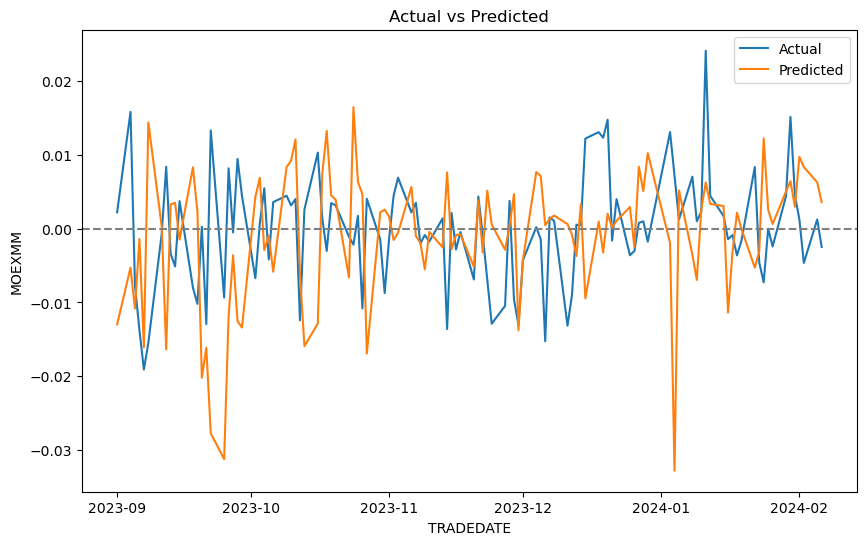

In [27]:
ts.get_visualisation(start_date='2023-09-01')

In [28]:
regressor = CatBoostRegressor()
y_pred_list = []
for X_train, y_train, X_test, y_test in tqdm(ts.folds):

    regressor.fit(X_train, y_train, verbose=0)

    y_pred = pd.Series(
        regressor.predict(X_test),
        index=X_test.index
    )

    y_pred_list.append(y_pred) 

100%|██████████| 20/20 [02:00<00:00,  6.05s/it]


In [29]:
ts.get_model_result(y_pred_list) 

MAE: 0.01
MASE: 0.78
ZBMAE: 1.06
SMAPE: 150.15%
MDA: 54.39%
DMDA: 52.50%


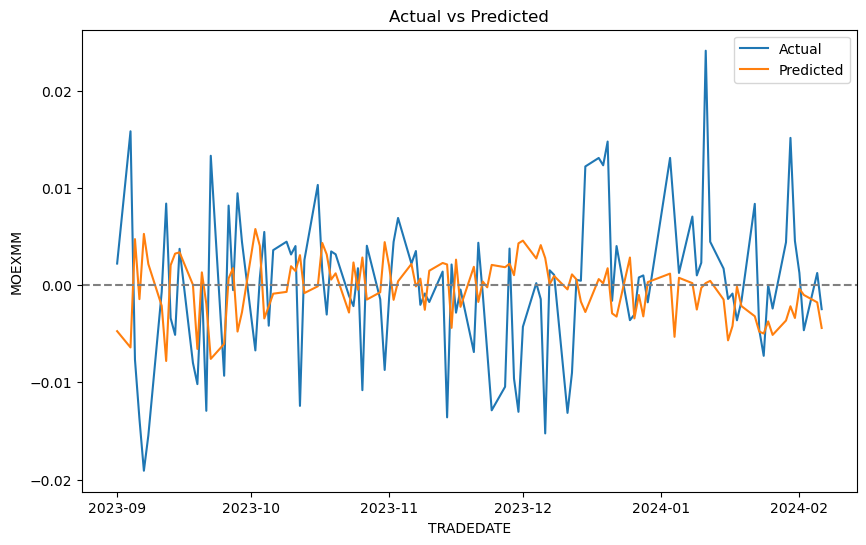

In [30]:
ts.get_visualisation(start_date='2023-09-01')